In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import datetime
import os
import csv
import io
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100

In [3]:
num_lags = 3
timesteps = 1
err_range = 0.5

In [11]:
# read in data
df = pd.read_csv('../j17wl_monthly.csv')
pd.DataFrame.reset_index(df, drop=True)
data_type = 'average' # or 'min' or 'max'
# standardize data
def z_score_calc(dataframe,col_name):
    sub = dataframe[col_name]
    mean = sub.mean()
    std = sub.std()
    dataframe['Z Scores'] = (sub - mean) / std
    return dataframe['Z Scores'], mean, std
z_scores = pd.DataFrame()
pd.DataFrame.reset_index(z_scores, drop=True)
z_scores['Year'] = df['year']
z_scores['Month'] = df['month']
z_scores['level_'+data_type] = df['level_'+data_type]
z_scores['Z Scores'], mean, std = z_score_calc(df,'level_'+data_type) # noramlization speeds up learning and leads to faster convergence
z_scores.to_csv("j17wl_monthly_z_scores.csv") 
# generate csv based on number of lags
def make_csv(num_lags,gwl_num,df,col_name,csv_name):
    result = pd.DataFrame()
    pd.DataFrame.reset_index(result, drop=True)
    data = df[col_name]
    pd.DataFrame.reset_index(data, drop=True)
    name = ""
    for i in range(num_lags):
        name = "Max GWL: t-" + str(num_lags-i)
        list_data = data[num_lags+gwl_num-1-i:(len(data)-i)]
        result[name] = np.array(list_data)
    if gwl_num > 1:
        result['Max GWL (predicted,updated): t+' + str(gwl_num-1)] = data[0:len(data)-num_lags-gwl_num+1]
    else:
        result['Max GWL (predicted,updated): t'] = data[0:len(data)-num_lags-gwl_num+1]
    #result = result.sample(frac=1)
    result.to_csv(csv_name)
make_csv(num_lags,timesteps,z_scores,'Z Scores','data.csv')
cols = []
for i in range(num_lags):
    cols.append(i+1)
# prepare data
ds_x = np.genfromtxt('data.csv',delimiter=",",usecols=cols)
ds_y = np.genfromtxt('data.csv',delimiter=",",usecols=num_lags+1)
ds_x = ds_x[1:] # remove header
ds_y = ds_y[1:]
ds_x = np.flip(ds_x,axis=0)
ds_y = np.flip(ds_y,axis=0)
# ~70% training
ds_train_x = ds_x[:int(0.7*len(ds_x))]
ds_train_y = ds_y[:int(0.7*len(ds_y))]
# ~20% validating
ds_val_x = ds_x[int(0.7*len(ds_x)):int(0.9*len(ds_x))]
ds_val_y = ds_y[int(0.7*len(ds_y)):int(0.9*len(ds_y))]
# ~10% testing
ds_test_x = ds_x[int(0.9*len(ds_y)):]
ds_test_y = ds_y[int(0.9*len(ds_y)):]

In [18]:
# build NN
epochs = 100
batch_size = 100
model = keras.Sequential()
model.add(keras.layers.Dense(10, activation='sigmoid', input_dim=num_lags))
model.add(keras.layers.Dense(10))
model.add(keras.layers.Dense(10))
model.add(keras.layers.Dense(10))
model.add(keras.layers.Dense(1)) # output layer; gives a 1D output
model.compile(optimizer='adam', loss='mse')
history = model.fit(ds_train_x, ds_train_y, batch_size=batch_size, epochs=epochs, validation_data=(ds_val_x,ds_val_y), verbose=2)
# apply to predictions
predictions = model.predict(ds_test_x)
r = []
for i in predictions:
    r.append(i[0])
result = np.array(r)
predicted_vals = result * std + mean
true_vals = ds_test_y * std + mean
diff = true_vals - predicted_vals
count_err = 0
count_1 = 0
for i in diff:
    if abs(i) <= err_range:
      count_err += 1
    if abs(i) <= 1.0:
      count_1 += 1
print("Predictions ±" + str(err_range) + " = " + str(count_err / len(diff) * 100) + "%")
print("Predictions ±1.0 = " + str(count_1 / len(diff) * 100) + "%")
corr_m = np.corrcoef(predicted_vals, true_vals)
r2 = corr_m[0,1] ** 2
print('R2 = ' + str(r2*100) + "%")

Epoch 1/100
8/8 - 0s - loss: 1.8410 - val_loss: 0.9059
Epoch 2/100
8/8 - 0s - loss: 1.1424 - val_loss: 0.7240
Epoch 3/100
8/8 - 0s - loss: 0.8289 - val_loss: 0.7091
Epoch 4/100
8/8 - 0s - loss: 0.6868 - val_loss: 0.6647
Epoch 5/100
8/8 - 0s - loss: 0.5719 - val_loss: 0.5612
Epoch 6/100
8/8 - 0s - loss: 0.4589 - val_loss: 0.4464
Epoch 7/100
8/8 - 0s - loss: 0.3546 - val_loss: 0.3578
Epoch 8/100
8/8 - 0s - loss: 0.2760 - val_loss: 0.3076
Epoch 9/100
8/8 - 0s - loss: 0.2161 - val_loss: 0.2823
Epoch 10/100
8/8 - 0s - loss: 0.1815 - val_loss: 0.2719
Epoch 11/100
8/8 - 0s - loss: 0.1665 - val_loss: 0.2695
Epoch 12/100
8/8 - 0s - loss: 0.1609 - val_loss: 0.2718
Epoch 13/100
8/8 - 0s - loss: 0.1602 - val_loss: 0.2705
Epoch 14/100
8/8 - 0s - loss: 0.1589 - val_loss: 0.2663
Epoch 15/100
8/8 - 0s - loss: 0.1571 - val_loss: 0.2628
Epoch 16/100
8/8 - 0s - loss: 0.1546 - val_loss: 0.2579
Epoch 17/100
8/8 - 0s - loss: 0.1529 - val_loss: 0.2538
Epoch 18/100
8/8 - 0s - loss: 0.1512 - val_loss: 0.2514
E

In [19]:
plt.rcParams['font.family'] = 'serif'
f='Times'

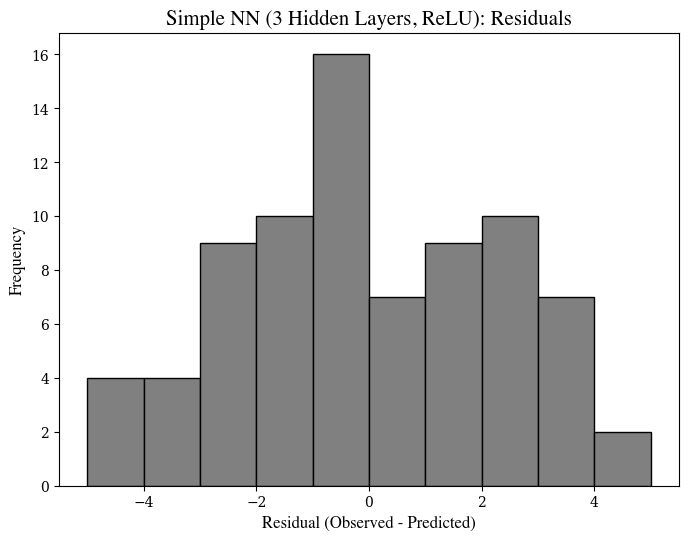

In [20]:
fig, ax = plt.subplots(1, 1)
ax.hist(diff,range=[-5, 5],facecolor='grey',edgecolor='black')
ax.set_title("Simple NN (3 Hidden Layers, ReLU): Residuals", family=f, size=15)
ax.set_xlabel("Residual (Observed - Predicted)", family=f, size=12)
ax.set_ylabel("Frequency", family=f, size=12)
plt.show()

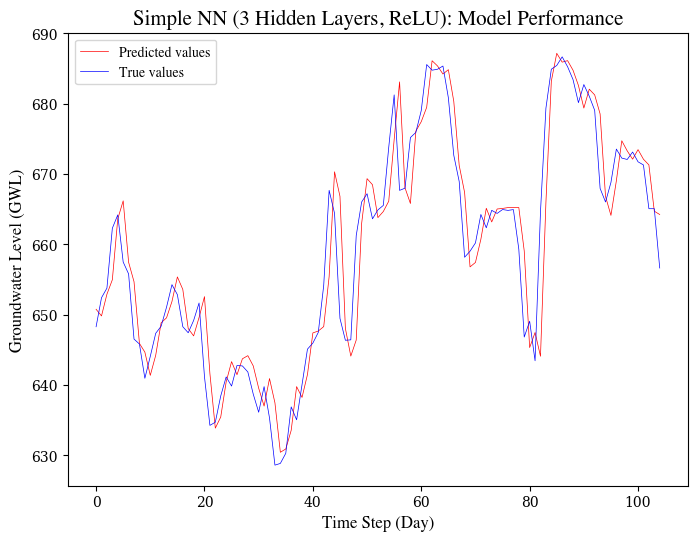

In [21]:
fig, ax = plt.subplots(1, 1)
ax.plot(predicted_vals,color='red', label = "Predicted values", linewidth=0.5)
ax.plot(true_vals,color='blue', label = "True values", linewidth=0.5)
ax.set_title("Simple NN (3 Hidden Layers, ReLU): Model Performance", family=f, size=15)
ax.set_xlabel("Time Step (Day)", family=f, size=12)
ax.set_ylabel("Groundwater Level (GWL)", family=f, size=12)
ax.legend(prop={'size': 10, 'family':f})

In [26]:
model.save("simple_nn_D")

INFO:tensorflow:Assets written to: simple_nn_D/assets


In [27]:
plt.rcParams['font.family'] = 'sans-serif'
f='Avenir'

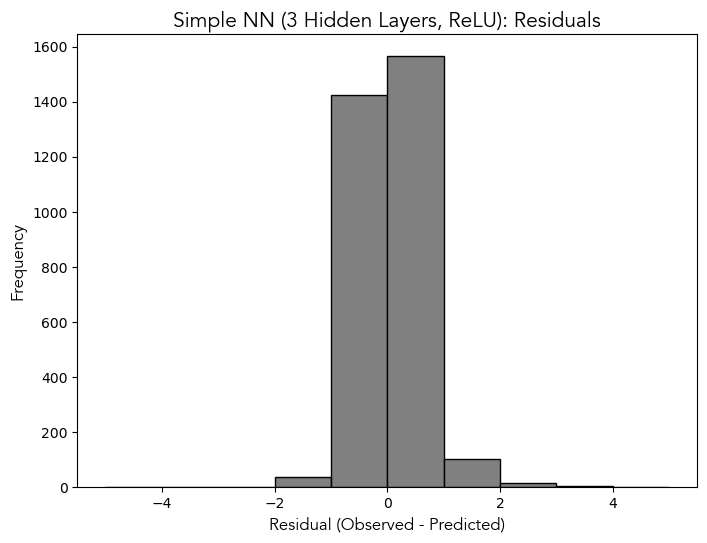

In [28]:
fig, ax = plt.subplots(1, 1)
ax.hist(diff,range=[-5, 5],facecolor='grey',edgecolor='black')
ax.set_title("Simple NN (3 Hidden Layers, ReLU): Residuals", family=f, size=15)
ax.set_xlabel("Residual (Observed - Predicted)", family=f, size=12)
ax.set_ylabel("Frequency", family=f, size=12)
plt.show()

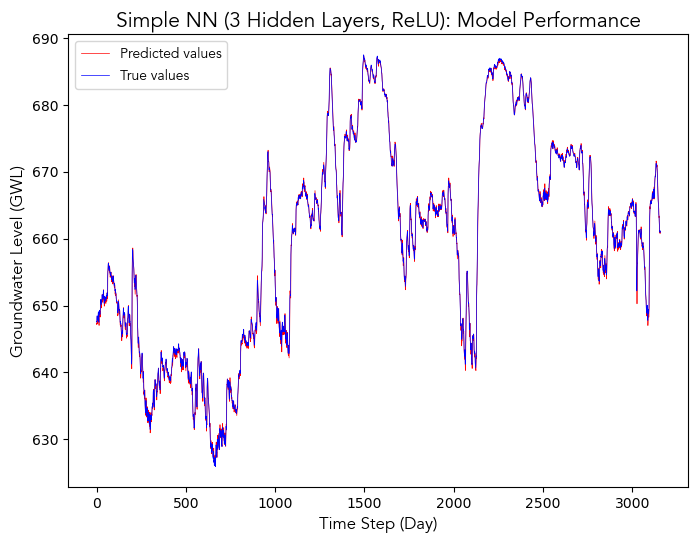

In [29]:
fig, ax = plt.subplots(1, 1)
ax.plot(predicted_vals,color='red', label = "Predicted values", linewidth=0.5)
ax.plot(true_vals,color='blue', label = "True values", linewidth=0.5)
ax.set_title("Simple NN (3 Hidden Layers, ReLU): Model Performance", family=f, size=15)
ax.set_xlabel("Time Step (Day)", family=f, size=12)
ax.set_ylabel("Groundwater Level (GWL)", family=f, size=12)
ax.legend(prop={'size': 10, 'family':f})